# Zero-Shot Classification

This notebook performs zero-shot classification on images of object in ngc1097 as captured by the Hubble Space Telescope from PHANGS.

In [326]:
%%capture
import import_ipynb
from access_images import get_cutouts


In [327]:
# imports libraries for data storage, and ML models & processors for classification
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import metrics
from tqdm.auto import tqdm

from PIL import Image
import numpy as np
import torch
import json
import os
from datasets import load_dataset

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

Resolving data files:   0%|          | 0/237 [00:00<?, ?it/s]

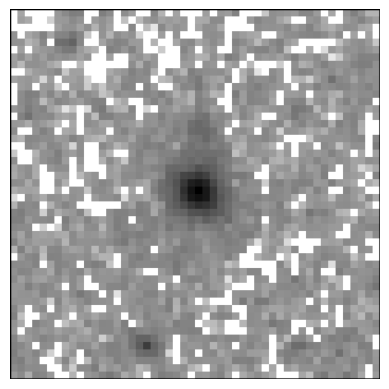

In [328]:

dataset_path = "../data/sorted/test_pngs"

dataset = load_dataset("imagefolder", data_dir=dataset_path)

label_to_label = {
    "0": "1",
    "1": "4",
    "2": "4",
    "3": "4",
    "4": "4",
    "5": "2",
    "6": "3",
    "7": "4",
    "8": "4",
    "9": "4",
    "10": "4",
    "11": "4",
    "12": "4"
}

def add_label(example):
    folder_name = example["label"]  # Label corresponds to folder name (numerical)
    example["label"] = label_to_label.get(str(folder_name), "Unknown Object")
    return example

# Apply the function

test_dataset = dataset['train']
test_dataset = test_dataset.map(add_label)

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LogNorm

# Separate images and labels
dataset_images = test_dataset["image"]
dataset_labels = test_dataset["label"]

log_normalized_images = []

for img in dataset_images:
    img = np.array(img, dtype=np.float32)  # Convert PIL image to NumPy float32 array

    # Ensure image has at least 2D shape for grayscale or 3D for RGB
    if len(img.shape) == 2:  # Grayscale image
        pass  
    elif len(img.shape) == 3:  # RGB image
        img = np.mean(img, axis=-1)  # Convert to grayscale

    img[img <= 0] = 1e-6  # Avoid log(0) errors

    # Apply log normalization
    norm = LogNorm(vmin=np.min(img), vmax=np.max(img))
    normalized_img = norm(img)  

    # Scale values back to [0, 255] for visualization
    normalized_img = (normalized_img - np.min(normalized_img)) / (np.max(normalized_img) - np.min(normalized_img)) * 255
    normalized_img = np.clip(normalized_img, 0, 255).astype(np.uint8)

    log_normalized_images.append(normalized_img)

# Convert back to PIL images
pil_images = [Image.fromarray(img) for img in log_normalized_images]

# Display the first normalized image
plt.imshow(pil_images[0], cmap="gray")  # "gray" ensures grayscale visualization
plt.axis("off")  # Hide axes
plt.show()


In [329]:
"""
# Pulls 400 images, roughly 100 per each class
cutouts = get_cutouts(400)

# Separate images and labels
images = [item[0] for item in cutouts]
labels = [item[1] for item in cutouts]

# Normalizes images to ensure proper colouring and pixel magnitudes
log_normalized_images = []
for img in images:
    img = img.astype(np.float32) 
    norm = LogNorm()
    normalized_img = norm(img) 
    
    normalized_img = (normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()) * 255
    normalized_img = np.clip(normalized_img, 0, 255).astype(np.uint8)
    log_normalized_images.append(normalized_img)

# Stores images in PIL array to be passed through the processor.
pil_images = [Image.fromarray(img) for img in log_normalized_images]
plt.imshow(pil_images[0], cmap='Greys')
plt.axis("off")
plt.show()
"""


'\n# Pulls 400 images, roughly 100 per each class\ncutouts = get_cutouts(400)\n\n# Separate images and labels\nimages = [item[0] for item in cutouts]\nlabels = [item[1] for item in cutouts]\n\n# Normalizes images to ensure proper colouring and pixel magnitudes\nlog_normalized_images = []\nfor img in images:\n    img = img.astype(np.float32) \n    norm = LogNorm()\n    normalized_img = norm(img) \n    \n    normalized_img = (normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()) * 255\n    normalized_img = np.clip(normalized_img, 0, 255).astype(np.uint8)\n    log_normalized_images.append(normalized_img)\n\n# Stores images in PIL array to be passed through the processor.\npil_images = [Image.fromarray(img) for img in log_normalized_images]\nplt.imshow(pil_images[0], cmap=\'Greys\')\nplt.axis("off")\nplt.show()\n'

In [330]:
# Sets computation device to whatever is available (likely CPU in this case)
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

# Specifices version of CLIP to be used from huggingface 
model_id = "openAI/clip-vit-base-patch32"

# Loads the model, tokenizer, and processor
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)


In [331]:
# Sets input prompt and tokenizes it using tokenizer


"""
prompt_one = "A bright star cluster with one peak and is symmetric"
prompt_two = "A bright star cluster with one peak but is asymmetric or elongated"
prompt_three = "A compact stellar association that is assymetric and has multiple peaks"
prompt_four = "Types of image noise, such as background galaxies, stars, fluff, image diffraction and others"

"""


prompt_one = "globular cluster, central peak, symmetrical, slighlty more extended than point source"
prompt_two = "open cluster, central peak, asymmetrical, elongated, slightly more extended relative to point source"
prompt_three = "compact stellar association, asymmetric, multiple peaks"
prompt_four = "not a star cluster or compact stellar association could be image artifacts, background galaxies, individual stars, or pairs of stars"


inputs_one = tokenizer(prompt_one, return_tensors="pt")
inputs_two = tokenizer(prompt_two, return_tensors="pt")
inputs_three = tokenizer(prompt_three, return_tensors="pt")
inputs_four = tokenizer(prompt_four, return_tensors="pt")

In [332]:
# Embeds the prompt into a vector space in shape suitable for the model
text_emb_one = model.get_text_features(**inputs_one)
text_emb_two = model.get_text_features(**inputs_two)
text_emb_three = model.get_text_features(**inputs_three)
text_emb_four = model.get_text_features(**inputs_four)

In [333]:

"""# Processor is used for image and text processing, however this instance is only for images and returns it as a tensor.
image = processor(
    text=None,
    images=pil_images[0], #Custom cluster dataset
    # images=dataset[0]['image'], #Imagenette dataset 
    return_tensors="pt",
    do_rescale=False
)['pixel_values'].to(device)
image.shape"""

'# Processor is used for image and text processing, however this instance is only for images and returns it as a tensor.\nimage = processor(\n    text=None,\n    images=pil_images[0], #Custom cluster dataset\n    # images=dataset[0][\'image\'], #Imagenette dataset \n    return_tensors="pt",\n    do_rescale=False\n)[\'pixel_values\'].to(device)\nimage.shape'

In [334]:
"""image.squeeze(0).T.shape"""


'image.squeeze(0).T.shape'

In [335]:
"""print(f"Min: {image.min()}, Max: {image.max()}")"""

'print(f"Min: {image.min()}, Max: {image.max()}")'

In [336]:

"""def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor

normalized_tensor = normalize_tensor(image.squeeze(0).T) #Normalize the tensor.
plt.imshow(normalized_tensor.cpu().numpy()) #Display the normalized tensor.
plt.axis("off")
plt.show()
normalized_tensor.shape"""


'def normalize_tensor(tensor):\n    min_val = tensor.min()\n    max_val = tensor.max()\n    normalized_tensor = (tensor - min_val) / (max_val - min_val)\n    return normalized_tensor\n\nnormalized_tensor = normalize_tensor(image.squeeze(0).T) #Normalize the tensor.\nplt.imshow(normalized_tensor.cpu().numpy()) #Display the normalized tensor.\nplt.axis("off")\nplt.show()\nnormalized_tensor.shape'

In [337]:
"""# Embeds image into vector space, similar to text embedding 
image_emb = model.get_image_features(normalized_tensor.T.unsqueeze(0))
image_emb.shape"""

'# Embeds image into vector space, similar to text embedding \nimage_emb = model.get_image_features(normalized_tensor.T.unsqueeze(0))\nimage_emb.shape'

In [338]:
batch_size = 10 # change depending on size of test set
image_arr = None

for i in tqdm(range(0, len(pil_images), batch_size)):
    # select batch of images
    batch = pil_images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    #conver to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    #add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape



  0%|          | 0/24 [00:00<?, ?it/s]

(237, 512)

In [339]:
image_arr.min(), image_arr.max() 

(np.float32(-8.0372305), np.float32(2.739624))

In [340]:
# Normalizes the image embeddings
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

In [341]:
image_arr = image_arr.T
image_arr.shape
image_arr.min(), image_arr.max()

(np.float32(-0.71744096), np.float32(0.25193596))

In [342]:
text_emb_one = text_emb_one.cpu().detach().numpy()
text_emb_two = text_emb_two.cpu().detach().numpy()
text_emb_three = text_emb_three.cpu().detach().numpy()
text_emb_four = text_emb_four.cpu().detach().numpy()

In [343]:
# Takes the dot product of each image and the prompt to determine similarities scores
scores_one = np.dot(text_emb_one, image_arr.T)
scores_two = np.dot(text_emb_two, image_arr.T)
scores_three = np.dot(text_emb_three, image_arr.T)
scores_four = np.dot(text_emb_four, image_arr.T)

In [344]:
# Takes the top 5 image scores for prompt 1 and stores them in an index array
top_k = 400
idx_one = np.argsort(-scores_one[0])[:top_k]

2.5264468


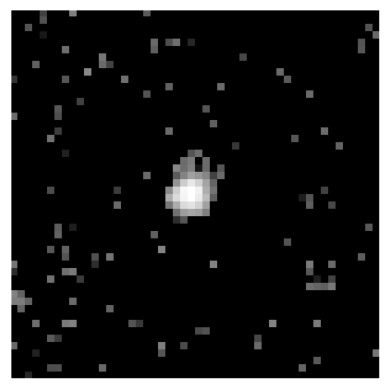

class2


In [345]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_one[0][idx_one[i]])
    plt.imshow(pil_images[idx_one[i]], cmap='Greys')
    plt.axis("off")
    plt.show()
    print(labels[idx_one[i]])

In [346]:
# Takes the top 5 image scores for prompt 2 and stores them in an index array
idx_two = np.argsort(-scores_two[0])[:top_k]

2.448632


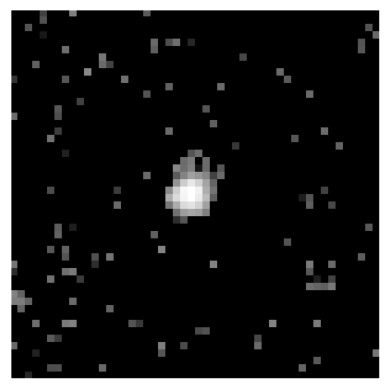

class2


In [347]:
# Prints the 5 images with the highest scores
for i in range(1):
    print(scores_two[0][idx_two[i]])
    plt.imshow(pil_images[idx_two[i]], cmap='Greys')
    plt.axis("off")
    plt.show()
    print(labels[idx_two[i]])

In [348]:
# Takes the top 5 image scores for prompt 3 and stores them in an index array
idx_three = np.argsort(-scores_three[0])[:top_k]

2.8094358


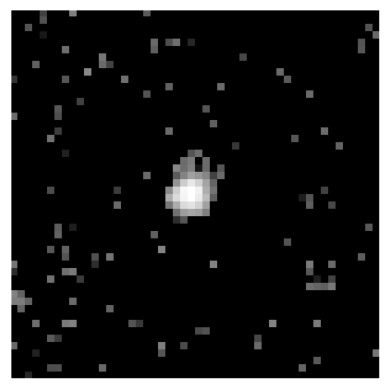

class2


In [349]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_three[0][idx_three[i]])
    plt.imshow(pil_images[idx_three[i]], cmap='Greys')
    plt.axis("off")
    plt.show()
    print(labels[idx_three[i]])


In [350]:
# Takes the top 5 image scores for prompt 3 and stores them in an index array
idx_four = np.argsort(-scores_four[0])[:top_k]

2.8183084


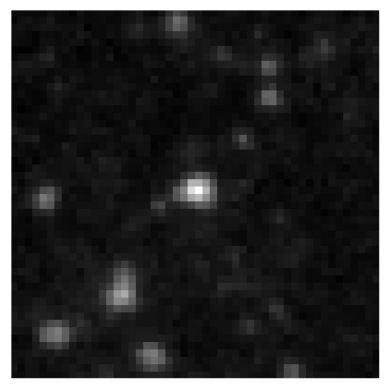

class2


In [351]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_four[0][idx_four[i]])
    plt.imshow(pil_images[idx_four[i]], cmap='Greys')
    plt.axis("off")
    plt.show()
    print(labels[idx_four[i]])


In [352]:
# Finds earliest occurence of each image in score indexes and assigns them to respective category
# Convert lists to dictionaries for O(1) lookups
pos_one = {img: i for i, img in enumerate(idx_one)}
pos_two = {img: i for i, img in enumerate(idx_two)}
pos_three = {img: i for i, img in enumerate(idx_three)}
pos_four = {img: i for i, img in enumerate(idx_four)}

cat_one = []
cat_two = []
cat_three = []
cat_four = []

# Get unique images from all three lists
all_images = set(idx_one) | set(idx_two) | set(idx_three) | set(idx_four)

for img in all_images:
    # Get positions, using a large default if missing
    pos1 = pos_one.get(img, float('inf'))
    pos2 = pos_two.get(img, float('inf'))
    pos3 = pos_three.get(img, float('inf'))
    pos4 = pos_four.get(img, float('inf'))

    # Determine which list contains the earliest occurrence
    min_pos = min(pos1, pos2, pos3, pos4)

    if min_pos == pos1:
        cat_one.append(img)
    elif min_pos == pos2:
        cat_two.append(img)
    elif min_pos == pos3:
        cat_three.append(img)
    elif min_pos == pos4:
        cat_four.append(img)

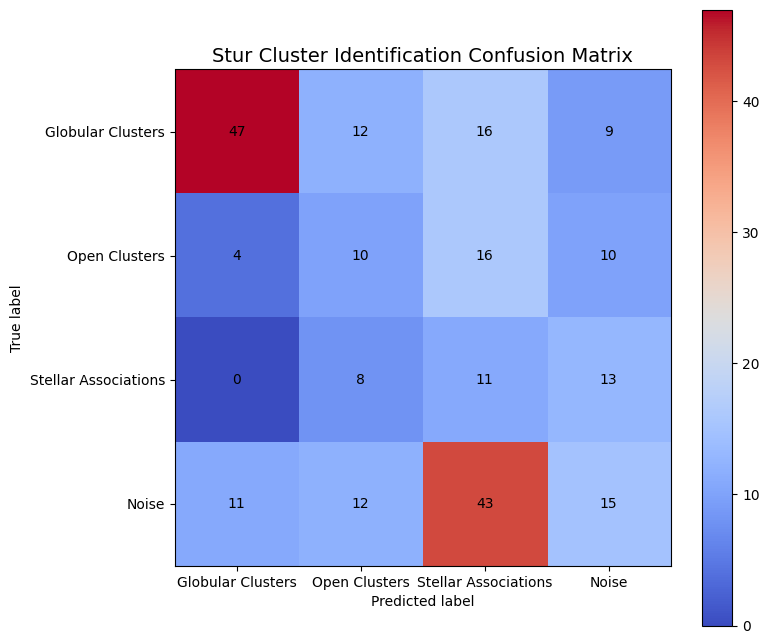

In [ ]:
actual = []
predicted = []

for i in cat_one:
    actual.append(dataset_labels[i])  
    predicted.append(1)  

for i in cat_two:
    actual.append(dataset_labels[i])
    predicted.append(2) 

for i in cat_three:
    actual.append(dataset_labels[i])
    predicted.append(3)  

for i in cat_four:
    actual.append(dataset_labels[i])
    predicted.append(4)  

actual = np.array(actual)
predicted = np.array(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[1, 2, 3, 4])

category_labels = ["Globular Clusters", "Open Clusters", "Stellar Associations", "Noise"]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=category_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(cmap="coolwarm", ax=ax, values_format="d")

for text in ax.texts:
    text.set_color("black")

plt.title("Stur Cluster Identification Confusion Matrix", fontsize=14)
plt.show()

In [ ]:
def precision(class_type, id):
    
    true_positive = 0
    false_positive = 0

    for i in class_type:
        if dataset_labels[i] == id:
            true_positive += 1
        else:
            false_positive += 1
    
    if (true_positive+false_positive) == 0:
        return 0
    
    prec_val = (true_positive / (true_positive+false_positive)) * 100

    return prec_val

In [ ]:
def recall(class_type, id):
    
    count = 0
    true_positive = 0
    false_negative = 0

    for i in dataset_labels:
        if i == id:
            count += 1

    for i in class_type:
        if dataset_labels[i] == id:
            true_positive += 1

    false_negative = count - true_positive

    if (true_positive+false_negative) == 0:
        return 0

    recall_val = (true_positive / (true_positive+false_negative)) * 100

    return recall_val

In [356]:
def f_one_score(precision_val, recall_val):

    if (precision_val+recall_val) == 0:
        return 0

    f_one = (2*precision_val*recall_val)/(precision_val+recall_val)
    return f_one

In [ ]:
def accuracy():

    correct = 0
    total = 0

    for i in dataset_labels:
        total += 1

    for i in cat_one:
        if dataset_labels[i] == "class1":
            correct += 1
    
    for i in cat_two:
        if dataset_labels[i] == "class2":
            correct += 1
    
    for i in cat_three:
        if dataset_labels[i] == "class3":
            correct += 1
    
    for i in cat_four:
        if dataset_labels[i] == "class4":
            correct += 1
    
    acc = (correct / total) * 100
    return acc


In [358]:
def calculate_and_store_metrics():
    results = {
        "Class 1": {
            "Precision": round(precision(cat_one, "class1"), 2),
            "Recall": round(recall(cat_one, "class1"), 2),
            "F1 Score": round(f_one_score(precision(cat_one, "class1"), recall(cat_one, "class1")), 2),
        },
        "Class 2": {
            "Precision": round(precision(cat_two, "class2"), 2),
            "Recall": round(recall(cat_two, "class2"), 2),
            "F1 Score": round(f_one_score(precision(cat_two, "class2"), recall(cat_two, "class2")), 2),
        },
        "Class 3": {
            "Precision": round(precision(cat_three, "class3"), 2),
            "Recall": round(recall(cat_three, "class3"), 2),
            "F1 Score": round(f_one_score(precision(cat_three, "class3"), recall(cat_three, "class3")), 2),
        },
        "Class 4": {
            "Precision": round(precision(cat_four, "class4"), 2),
            "Recall": round(recall(cat_four, "class4"), 2),
            "F1 Score": round(f_one_score(precision(cat_four, "class4"), recall(cat_four, "class4")), 2),
        },
        "Overall Accuracy": round(accuracy(), 2),
    }

    filepath = "../data/zero_shot_metrics.json"
    if os.path.exists(filepath):
        with open(filepath, "r") as f:
            try:
                all_results = json.load(f)
                if not isinstance(all_results, list) or not all_results:
                    all_results = [{}]
            except json.JSONDecodeError:
                all_results = [{}]
    else:
        all_results = [{}]

    existing_metrics = all_results[0]

    for class_name, metrics in results.items():
        if class_name == "Overall Accuracy":
            if class_name in existing_metrics:
                existing_metrics[class_name] = str(existing_metrics[class_name]) + ", " + str(metrics)
            else:
                existing_metrics[class_name] = metrics
        elif class_name in existing_metrics:
            for metric_name, metric_value in metrics.items():
                existing_metrics[class_name][metric_name] = str(existing_metrics[class_name][metric_name]) + ", " + str(metric_value)
        else:
            existing_metrics[class_name] = metrics

    with open(filepath, "w") as f:
        json.dump(all_results, f, indent=4)

calculate_and_store_metrics()